In [2]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
REFRESH_TOKEN = os.getenv("REFRESH_TOKEN")
# ... existing code ...

# Overview
## Here's what we'll aim to achieve:

### List runs 
Display runs in a structured format.
### Calculate Personal Records (PRs)
Identify best times over standard distances, considering all sub-runs.
### Visualize PRs
Plot best pace against distance.
### Create an Animated History of PRs
Show how PRs have evolved over time.
### Optional - Update Strava Descriptions
Add insights back to Strava run descriptions (requires Strava API access with write permissions).


In [1]:
import pandas as pd
from datetime import timedelta

# Load your data
df = pd.read_csv('data/my_activity_data=20240926202601.csv')

# Filter for running activities
running_df = df[df['sport_type'] == 'Run'].copy()

# Convert date columns to datetime
running_df['start_date'] = pd.to_datetime(running_df['start_date'])

# Calculate pace in min/km
running_df['distance_km'] = running_df['distance'] / 1000
running_df['pace_min_per_km'] = (running_df['moving_time'] / 60) / running_df['distance_km']

# Create a display DataFrame
display_df = running_df[['start_date', 'distance_km', 'moving_time', 'pace_min_per_km', 'id']].copy()

# Format moving_time
display_df['moving_time'] = display_df['moving_time'].apply(lambda x: str(timedelta(seconds=x)))

# Format pace
display_df['pace_min_per_km'] = display_df['pace_min_per_km'].apply(lambda x: f"{int(x):02d}'{int((x - int(x)) * 60):02d}\"/km")

# Add URL (assuming you have your athlete ID)
athlete_id = 'your_athlete_id'  # Replace with your actual athlete ID
display_df['url'] = 'https://www.strava.com/activities/' + running_df['id'].astype(str)

# Reset index for display purposes
display_df.reset_index(drop=True, inplace=True)
display_df.index.name = 'run #'

# Display the DataFrame
print(display_df[['start_date', 'distance_km', 'moving_time', 'pace_min_per_km', 'url']])


                     start_date  distance_km moving_time pace_min_per_km  \
run #                                                                      
0     2024-09-24 19:10:03+00:00       7.1827     0:44:13       06'09"/km   
1     2024-09-22 08:43:53+00:00       8.4881     0:57:23       06'45"/km   
2     2024-09-19 17:39:28+00:00       8.7435     0:53:54       06'09"/km   
3     2024-09-16 17:59:38+00:00       4.1990     0:28:17       06'44"/km   
4     2024-09-15 07:37:08+00:00      10.1138     0:55:17       05'27"/km   
...                         ...          ...         ...             ...   
182   2020-09-03 17:42:38+00:00       2.1236     0:09:59       04'42"/km   
183   2020-08-30 14:13:52+00:00       2.1893     0:10:04       04'35"/km   
184   2020-08-27 17:42:35+00:00       2.4639     0:12:03       04'53"/km   
185   2020-07-24 10:09:32+00:00       2.4206     0:12:30       05'09"/km   
186   2020-07-18 18:22:25+00:00       3.5764     0:18:11       05'05"/km   

           

# Calculate Personal Records (PRs)
To find best times over standard distances by considering all sub-runs within runs, we'll need to process GPS data. However, since we only have summary data in the CSV, we'll simulate this using the available data.


# Approach
For each run, we'll assume a constant pace throughout the run.
We'll generate sub-run times for standard distances up to the total distance of the run.

In [6]:
import numpy as np
from datetime import timedelta

# Define the distances we're interested in (in meters)
standard_distances = [400, 800, 1000, 1500, 5000, 10000, 15000, 21097.5]  # 1K, 5K, 10K, Half Marathon

# Initialize a dictionary to store PRs
pr_tables = {distance: [] for distance in standard_distances}

# Iterate over runs
for idx, row in running_df.iterrows():
    total_distance = row['distance']  # in meters
    total_time = row['moving_time']  # in seconds
    pace = total_time / total_distance  # seconds per meter
    
    # For each standard distance, check if this run can be considered
    for dist in standard_distances:
        if total_distance >= dist:
            time_for_dist = pace * dist  # time in seconds
            pr_tables[dist].append({
                'date': row['start_date'],
                'time': time_for_dist,
                'pace': (time_for_dist / dist) * 1000,  # pace in sec/km
                'run_id': row['id'],
                'url': f"https://www.strava.com/activities/{row['id']}",
                'total_run_distance': total_distance
            })

# For each distance, find the best time and create a formatted table
for dist in standard_distances:
    print(f"\n\n== Best {dist/1000:.1f}km Times ==\n")
    
    # Sort the list for this distance by time (fastest first)
    pr_list = sorted(pr_tables[dist], key=lambda x: x['time'])
    
    # Create a formatted table
    table = "| Rank | Time     | Date       | Pace      | Total Distance | Activity Link |\n"
    table += "|------|----------|------------|-----------|----------------|---------------|\n"
    
    for idx, run in enumerate(pr_list[:10], start=1):
        time_str = str(timedelta(seconds=run['time'])).split('.')[0]
        pace_str = f"{int(run['pace'] // 60):02d}'{int(run['pace'] % 60):02d}\"/km"
        date_str = run['date'].strftime('%Y-%m-%d')
        total_distance = run['total_run_distance'] / 1000
        
        table += f"| {idx:<4} | {time_str:<8} | {date_str:<10} | {pace_str:<9} | {total_distance:<14.2f}km | [Strava]({run['url']}) |\n"
    
    print(table)



== Best 0.4km Times ==

| Rank | Time     | Date       | Pace      | Total Distance | Activity Link |
|------|----------|------------|-----------|----------------|---------------|
| 1    | 0:01:46  | 2020-12-04 | 04'26"/km | 2.25          km | [Strava](https://www.strava.com/activities/10290286232) |
| 2    | 0:01:47  | 2020-09-20 | 04'29"/km | 2.22          km | [Strava](https://www.strava.com/activities/10290286218) |
| 3    | 0:01:49  | 2020-09-10 | 04'34"/km | 2.18          km | [Strava](https://www.strava.com/activities/10290286192) |
| 4    | 0:01:49  | 2020-10-05 | 04'34"/km | 1.01          km | [Strava](https://www.strava.com/activities/10290286216) |
| 5    | 0:01:50  | 2020-08-30 | 04'35"/km | 2.19          km | [Strava](https://www.strava.com/activities/10290286167) |
| 6    | 0:01:50  | 2020-10-19 | 04'36"/km | 1.21          km | [Strava](https://www.strava.com/activities/10290286220) |
| 7    | 0:01:52  | 2023-01-21 | 04'40"/km | 1.01          km | [Strava](https://www.s

# Visualize Personal Records
Plot the best pace as a function of the run's distance, considering all sub-runs.

# Approach
For each run, calculate pace at each standard distance up to the total run distance.
Plot these paces against the distances.

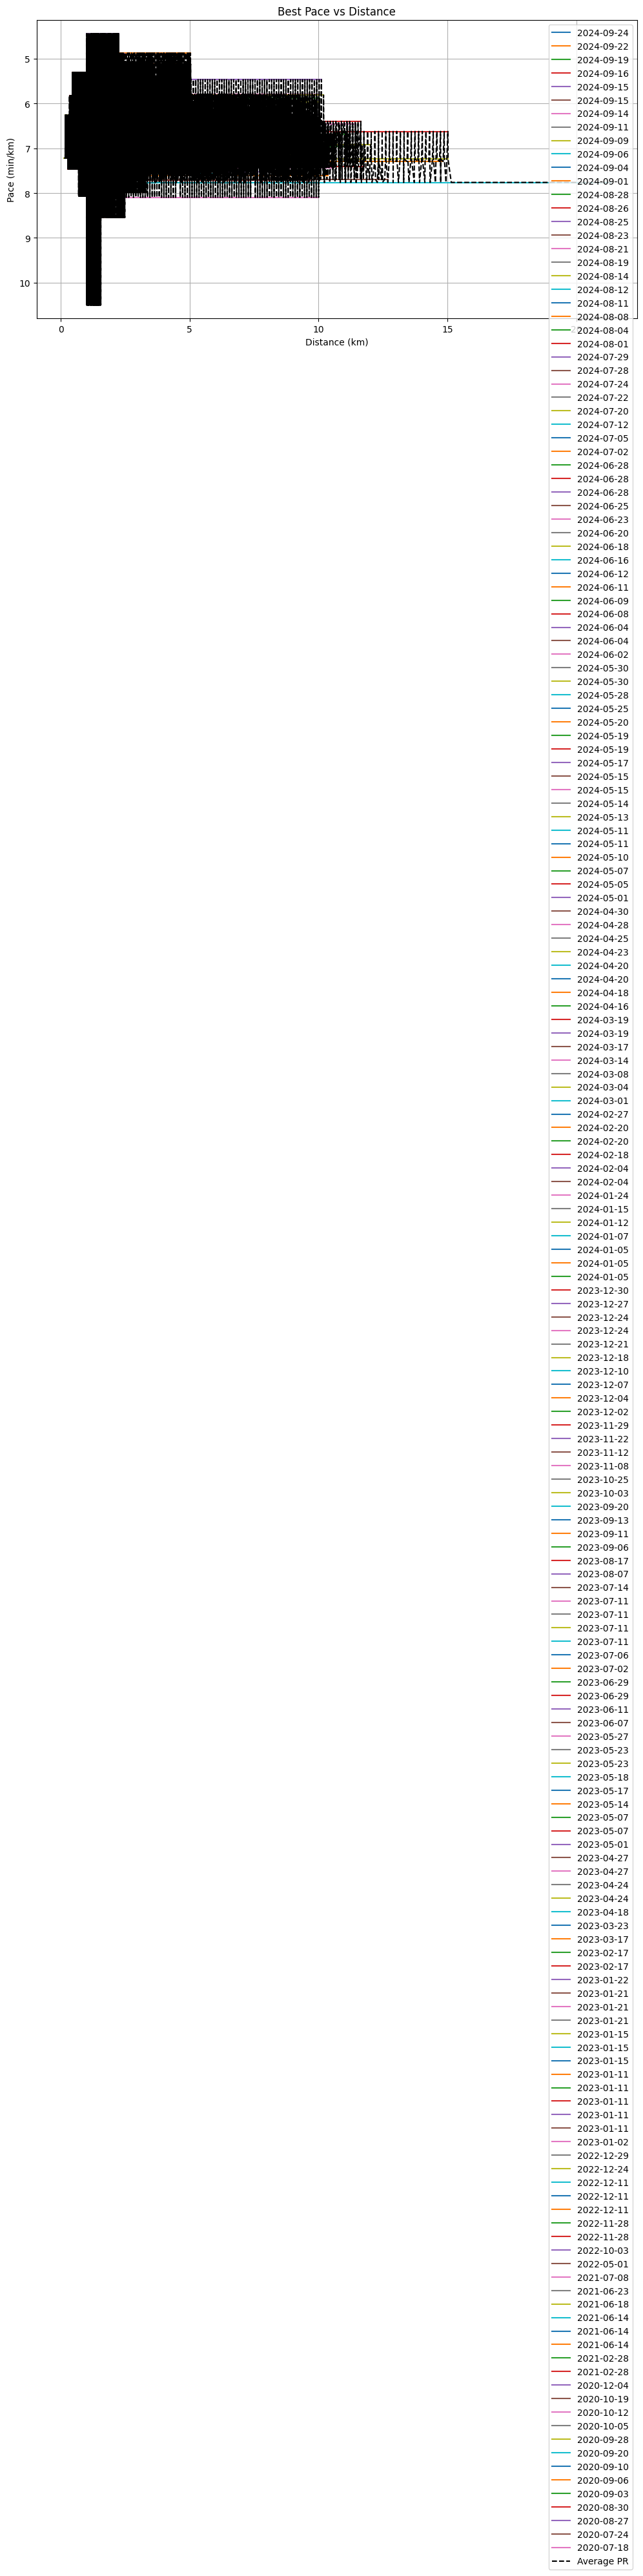

In [4]:
import matplotlib.pyplot as plt

# Collect data for plotting
plot_data = []

for idx, row in running_df.iterrows():
    total_distance = row['distance']  # in meters
    total_time = row['moving_time']  # in seconds
    pace = total_time / total_distance  # seconds per meter

    # Generate distances up to total_distance
    distances = np.linspace(1000, total_distance, num=100)  # Adjust num for resolution
    times = distances * pace  # times for the distances
    paces = (times / distances) * 1000  # pace in sec/km

    plot_data.append({
        'distances': distances / 1000,  # Convert to km
        'paces': paces / 60,  # Convert to min/km
        'date': row['start_date'],
        'run_id': row['id']
    })

# Plotting
plt.figure(figsize=(12, 6))

for run in plot_data:
    plt.plot(run['distances'], run['paces'], label=run['date'].strftime('%Y-%m-%d'))

# Calculate average PR curve
all_distances = np.array([])
all_paces = np.array([])

for run in plot_data:
    all_distances = np.concatenate((all_distances, run['distances']))
    all_paces = np.concatenate((all_paces, run['paces']))

# Create average PR curve
df_plot = pd.DataFrame({'distance': all_distances, 'pace': all_paces})
average_pr = df_plot.groupby('distance').min().reset_index()
plt.plot(average_pr['distance'], average_pr['pace'], '--', color='black', label='Average PR')

plt.xlabel('Distance (km)')
plt.ylabel('Pace (min/km)')
plt.title('Best Pace vs Distance')
plt.legend()
plt.gca().invert_yaxis()  # Faster pace at top
plt.grid(True)
plt.show()


# Create an Animated History of PRs
Show how PRs have evolved over time.

# Approach
For each run in chronological order, update the PR curve.
Generate a plot for each step.
Combine the plots into an animated GIF.

In [5]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio
from tqdm import tqdm

# Sort runs by date
running_df.sort_values('start_date', inplace=True)
running_df.reset_index(drop=True, inplace=True)

# Initialize PR curve
pr_curve = pd.DataFrame(columns=['distance', 'pace'])

# List to store frames
filenames = []

# Create a directory to store frames
import os
if not os.path.exists('frames'):
    os.makedirs('frames')

# Iterate over runs
for idx, row in tqdm(running_df.iterrows(), total=running_df.shape[0]):
    total_distance = row['distance']
    total_time = row['moving_time']
    pace = total_time / total_distance

    distances = np.linspace(1000, total_distance, num=50)
    times = distances * pace
    paces = (times / distances) * 1000

    run_df = pd.DataFrame({
        'distance': distances / 1000,  # km
        'pace': paces / 60  # min/km
    })

    # Update PR curve
    if pr_curve.empty:
        pr_curve = run_df.copy()
    else:
        combined = pd.concat([pr_curve, run_df])
        pr_curve = combined.groupby('distance').min().reset_index()

    # Plot current PR curve and the run
    plt.figure(figsize=(12, 6))
    plt.plot(run_df['distance'], run_df['pace'], label=f"Run on {row['start_date'].date()}")
    plt.plot(pr_curve['distance'], pr_curve['pace'], '--', color='black', label='Current PR')
    plt.xlabel('Distance (km)')
    plt.ylabel('Pace (min/km)')
    plt.title(f'PR Evolution up to {row["start_date"].date()}')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.grid(True)

    # Save frame
    filename = f'frames/frame_{idx}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

# Create animated GIF
with imageio.get_writer('pr_history.gif', mode='I', duration=1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Cleanup frames
for filename in set(filenames):
    os.remove(filename)
os.rmdir('frames')


100%|██████████| 187/187 [00:29<00:00,  6.34it/s]
C:\Users\fedil\AppData\Local\Temp\ipykernel_7696\1630117046.py:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Overview
We'll accomplish the following steps:

Fetch Detailed GPS Data: Use the Strava API to get detailed stream data (time, distance, lat/lng) for each run.

Process Each Run: Compute cumulative distances and times, and find the best pace over all possible sub-runs.

Efficiently Calculate Best Pace: Implement an algorithm to efficiently find the best average pace for all distances.

Plot the Best Pace vs. Distance: Create a plot that shows the best pace as a function of distance, considering all sub-runs.

Compare Individual Runs: Optionally, compare a specific run against the all-time PR curve.

Function to Refresh Access Token


In [7]:
import requests
import time

def get_access_token(client_id, client_secret, refresh_token):
    response = requests.post(
        url='https://www.strava.com/oauth/token',
        data={
            'client_id': client_id,
            'client_secret': client_secret,
            'refresh_token': refresh_token,
            'grant_type': 'refresh_token',
            'f': 'json'
        }
    )
    access_token = response.json()['access_token']
    expires_at = response.json()['expires_at']
    expires_in = response.json()['expires_in']
    return access_token, expires_at

Fetch Activity IDs

Assuming we have already fetched the activities and have their IDs.

In [8]:
# Load your activities DataFrame
activities_df = pd.read_csv('data/my_activity_data=20240929010236.csv')

# Filter for running activities
running_activities = activities_df[activities_df['sport_type'] == 'Run']
activity_ids = running_activities['id'].tolist()

Fetch Streams for Each Activity

We'll fetch the streams for each activity, which includes time, distance, and optionally altitude and velocity_smooth.

In [9]:
def fetch_activity_streams(activity_id, access_token):
    url = f'https://www.strava.com/api/v3/activities/{activity_id}/streams'
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    params = {
        'keys': 'time,distance',
        'key_by_type': 'true'
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch streams for activity {activity_id}")
        return None


Loop to Fetch All Streams


In [13]:
from tqdm import tqdm
import os
import json

access_token, expires_at = get_access_token(CLIENT_ID, CLIENT_SECRET, REFRESH_TOKEN)

import time
from requests.exceptions import RequestException

max_retries = 3
base_delay = 2

for activity_id in tqdm(activity_ids):
    stream_file = f'streams/{activity_id}.json'
    if os.path.exists(stream_file):
        continue  # Skip if already fetched

    for attempt in range(max_retries):
        try:
            # Refresh token if expired
            if time.time() > expires_at - 100:
                access_token, expires_at = get_access_token(CLIENT_ID, CLIENT_SECRET, REFRESH_TOKEN)

            streams = fetch_activity_streams(activity_id, access_token)
            if streams:
                with open(stream_file, 'w') as f:
                    json.dump(streams, f)
                break  # Success, exit retry loop
        except RequestException as e:
            print(f"Error fetching streams for activity {activity_id}: {e}")
            if attempt < max_retries - 1:
                sleep_time = base_delay * (2 ** attempt)  # Exponential backoff
                print(f"Retrying in {sleep_time} seconds...")
                time.sleep(sleep_time)
            else:
                print(f"Failed to fetch streams for activity {activity_id} after {max_retries} attempts")
    
    time.sleep(base_delay)  # Base delay between successful requests


100%|██████████| 188/188 [03:24<00:00,  1.09s/it]


Note:

Rate Limits: Strava imposes rate limits.

Caching: We store the streams locally to avoid redundant API calls.

From Strava API documentation:

### Rate Limits

Strava API usage is limited on a per-application basis using both a 15-minute and daily request limit. Applications have an overall rate limit as well as a separate rate limit associated with the endpoints we consider “non-upload” endpoints. The default overall rate limit allows 200 requests every 15 minutes, with up to 2,000 requests per day. The default “non-upload” rate limit allows 100 requests every 15 minutes, with up to 1,000 requests per day.


# Process Each Run
We will process the streams to compute cumulative distances and times and find the best pace over all possible sub-runs.

## Function to Process a Single Run

In [45]:
def process_run(activity_id):
    stream_file = f'streams/{activity_id}.json'
    with open(stream_file, 'r') as f:
        streams = json.load(f)

    time_data = streams['time']['data']  # Cumulative time in seconds
    distance_data = streams['distance']['data']  # Cumulative distance in meters

    return time_data, distance_data


## Efficiently Calculate Best Pace
We need an efficient algorithm to find the best (lowest) average pace for all possible distances.

### Algorithm Explanation
To avoid the computational complexity of checking all possible sub-runs (O(n^2)), we can use a sliding window approach.

However, for variable distances, a more efficient method is to:

For each possible distance increment (e.g., every 10 meters), we keep track of the minimal time (and thus minimal pace) needed to cover that distance.
We can also use a prefix sum array and dynamic programming techniques to optimize the process.

### Implementation

In [46]:
import numpy as np

def format_pace(pace):
    minutes = int(pace)
    seconds = int((pace - minutes) * 60)
    return f"{minutes}:{seconds:02d}"

def compute_best_pace(time_data, distance_data, min_distance=100, max_distance=None, step=10):
    """
    Computes the best pace over all possible sub-runs.

    Parameters:
    - time_data: list of cumulative time (seconds)
    - distance_data: list of cumulative distance (meters)
    - min_distance: minimum distance to consider (meters)
    - max_distance: maximum distance to consider (meters)
    - step: distance increment to consider (meters)

    Returns:
    - distances: array of distances considered
    - best_paces: array of best paces (seconds per km) at each distance
    """
    n = len(time_data)
    if max_distance is None:
        max_distance = distance_data[-1]

    distances = np.arange(min_distance, max_distance + step, step)
    best_paces = np.full_like(distances, np.inf, dtype=float)

    # Build arrays for efficient computation
    time_array = np.array(time_data)
    distance_array = np.array(distance_data)

    # For each possible start index
    for i in range(n):
        # For each possible end index from i+1 to n
        for j in range(i + 1, n):
            dist = distance_array[j] - distance_array[i]
            if dist < min_distance:
                continue
            if dist > max_distance:
                break  # Since distance is cumulative, no need to check further

            time = time_array[j] - time_array[i]
            pace = (time / dist) * 1000  # seconds per km

            # Find the index in distances array
            idx = int((dist - min_distance) / step)
            if pace < best_paces[idx]:
                best_paces[idx] = pace

    return distances, best_paces

# This approach may still be computationally heavy for large datasets.
# To optimize further, consider limiting the number of points or implementing more efficient algorithms.



### Making the PR Curve (logarithmic regression)

In [47]:
import numpy as np
from scipy import optimize

def logarithmic_regression(x, a, b):
    return a + b * np.log(x)

def fit_logarithmic_regression(distances, paces):
    # Remove any infinite or NaN values
    valid_indices = np.isfinite(paces)
    valid_distances = distances[valid_indices]
    valid_paces = paces[valid_indices]
    
    # Fit the logarithmic regression
    params, _ = optimize.curve_fit(logarithmic_regression, valid_distances, valid_paces)
    return params

## Plot the Best Pace vs. Distance
We can now plot the best pace as a function of distance.

### Process All Runs

In [48]:
def compute_overall_best_pace(activity_ids, min_distance=100, max_distance=50000, step=100):
    distances = np.arange(min_distance, max_distance + step, step)
    overall_best_paces = np.full_like(distances, np.inf, dtype=float)

    for activity_id in tqdm(activity_ids):
        try:
            time_data, distance_data = process_run(activity_id)
        except FileNotFoundError:
            print(f"File not found for activity {activity_id}. Skipping...")
            continue

        max_run_distance = distance_data[-1]
        activity_max_distance = min(max_distance, max_run_distance)
        activity_distances, activity_best_paces = compute_best_pace(
            time_data,
            distance_data,
            min_distance=min_distance,
            max_distance=activity_max_distance,
            step=step
        )

        # Update overall best paces
        for idx, pace in enumerate(activity_best_paces):
            if pace < overall_best_paces[idx]:
                overall_best_paces[idx] = pace
                
    # Calculate logarithmic regression curve
    a, b = fit_logarithmic_regression(distances, overall_best_paces)
    regression_curve = logarithmic_regression(distances, a, b)
    
    return distances, overall_best_paces, regression_curve


## Plotting 

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import os

def plot_best_pace_vs_distance(distances, best_paces, regression_curve, min_distance, max_distance, step):
    # Convert pace to min/km
    paces_min_per_km = best_paces / 60
    regression_min_per_km = regression_curve / 60

    # Convert distances to km
    distances_km = distances / 1000

    plt.figure(figsize=(16, 10))
    
    # Create a line collection for the best pace curve
    points = np.array([distances_km, paces_min_per_km]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a color array based on whether the pace is above or below the regression
    colors = np.where(paces_min_per_km > regression_min_per_km, 'orange', 'green')
    
    # Create a LineCollection
    lc = LineCollection(segments, colors=colors)
    
    # Plot the best pace curve
    plt.gca().add_collection(lc)
    
    # Plot regression curve
    plt.semilogx(distances_km, regression_min_per_km, '--', label='Logarithmic Regression', color='red', linewidth=2)
    
    plt.xlabel('Distance (km)')
    plt.ylabel('Best Pace (min/km)')
    plt.title('Best Pace vs Distance (Log Scale)')
    plt.gca().invert_yaxis()  # Lower paces (faster) at the top
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    # Set x and y limits
    plt.xlim(distances_km[0], distances_km[-1])
    plt.ylim(max(paces_min_per_km), min(paces_min_per_km))
    
    # Customize x-axis ticks
    major_ticks = [0.4, 0.8, 1, 1.5, 2, 5, 10, 21.1]
    plt.xticks(major_ticks, [f'{x:.1f}' for x in major_ticks])
    
    # Add minor ticks
    plt.gca().xaxis.set_minor_locator(plt.LogLocator(subs=np.arange(2, 10) * 0.1, numticks=100))
    
    # Create custom legend
    legend_elements = [
        Line2D([0], [0], color='green', label='Best Pace (overperforming)'),
        Line2D([0], [0], color='orange', label='Best Pace (underperforming)'),
        Line2D([0], [0], color='red', linestyle='--', label='Logarithmic Regression (pace prediction)')
    ]
    plt.legend(handles=legend_elements)
    
    # Add vertical and horizontal lines for specific distances
    distances_to_mark = [0.4, 0.8, 1, 1.5, 2, 5, 10, 21.1]
    for dist in distances_to_mark:
        plt.axvline(x=dist, color='gray', linestyle=':', alpha=0.7)
        plt.text(dist, plt.ylim()[0], f'{dist}km', rotation=90, va='bottom', ha='right', alpha=0.7)
        
        # Find the closest pace for this distance
        idx = np.argmin(np.abs(distances_km - dist))
        pace = paces_min_per_km[idx]
        
        # Add horizontal line and text for pace
        plt.axhline(y=pace, color='lightblue', linestyle=':', alpha=0.7, xmax=np.log(dist)/np.log(plt.xlim()[1]))
        plt.text(plt.xlim()[0], pace, format_pace(pace), ha='left', va='bottom', alpha=0.7, color='blue')
    
    # Format y-axis ticks
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_pace(x)))
    
    # Save the plot with parameters in the filename
    output_folder = 'output'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    plot_filename = os.path.join(output_folder, f'best_pace_vs_distance_log_min{min_distance}_max{max_distance}_step{step}.png')
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved as {plot_filename}")

## Execute the Analysis


100%|██████████| 188/188 [09:02<00:00,  2.89s/it]


Data saved as best_pace_data_min400_max15000_step100.csv


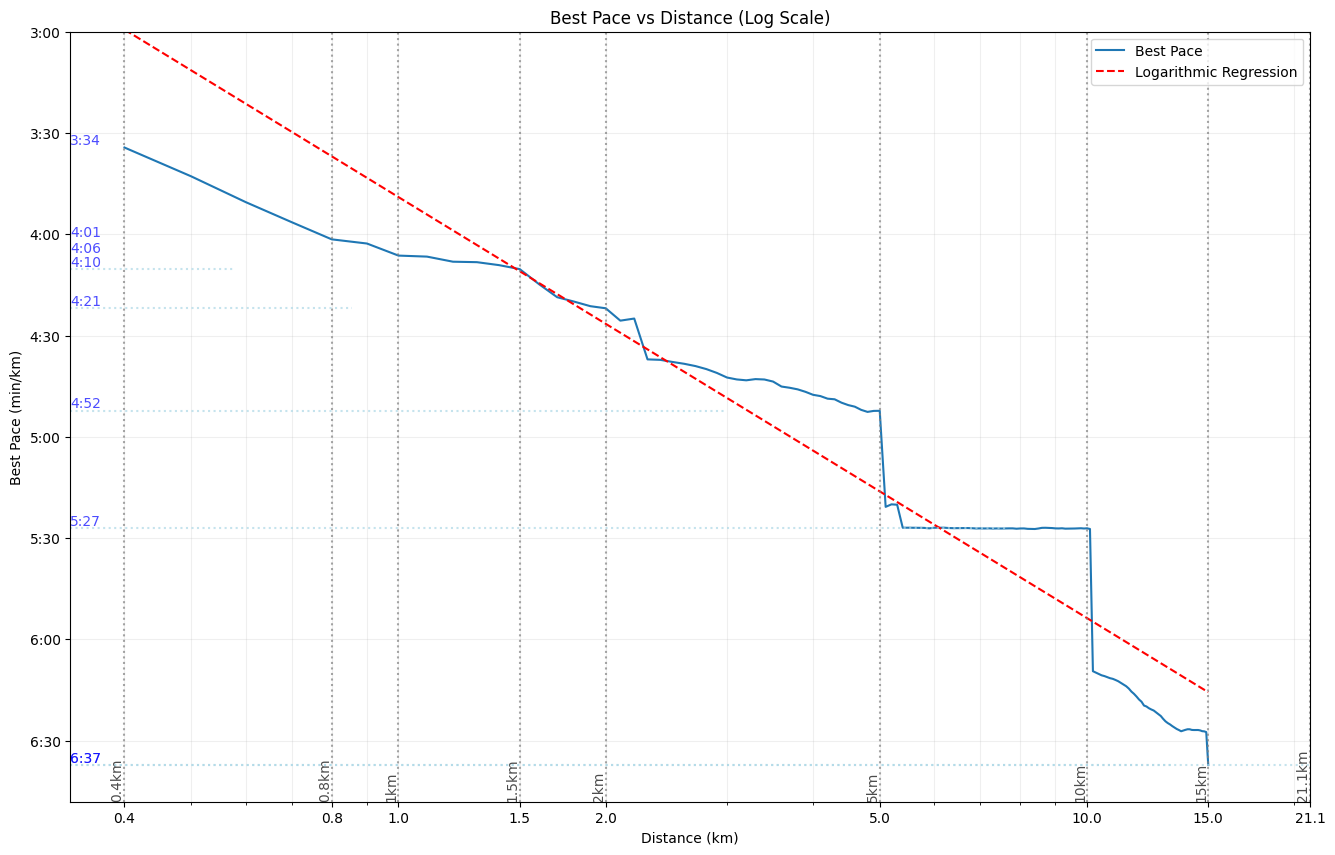

Plot saved as best_pace_vs_distance_log_min400_max15000_step100.png


In [37]:
### ADD THE CONVERSION NEXT

# Set parameters
MIN_DISTANCE = 400  # meters
MAX_DISTANCE = 15000  # meters (15 km)
STEP = 100  # meters

distances, best_paces, regression_curve = compute_overall_best_pace(
    activity_ids,
    min_distance=MIN_DISTANCE,
    max_distance=MAX_DISTANCE,
    step=STEP
)

# Create DataFrame
df = pd.DataFrame({
    'distance': distances,
    'best_pace': best_paces,
    'regression_curve': regression_curve
})

# Ensure output folder exists
output_folder = 'output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save the data to a CSV file with parameters in the filename
csv_filename = os.path.join(output_folder, f'best_pace_data_min{MIN_DISTANCE}_max{MAX_DISTANCE}_step{STEP}.csv')
df.to_csv(csv_filename, index=False)
print(f"Data saved as {csv_filename}")

# Plot and save the graph
plot_best_pace_vs_distance(distances, best_paces, regression_curve, MIN_DISTANCE, MAX_DISTANCE, STEP)

Data saved as output\best_pace_data_min400_max15000_step100.csv


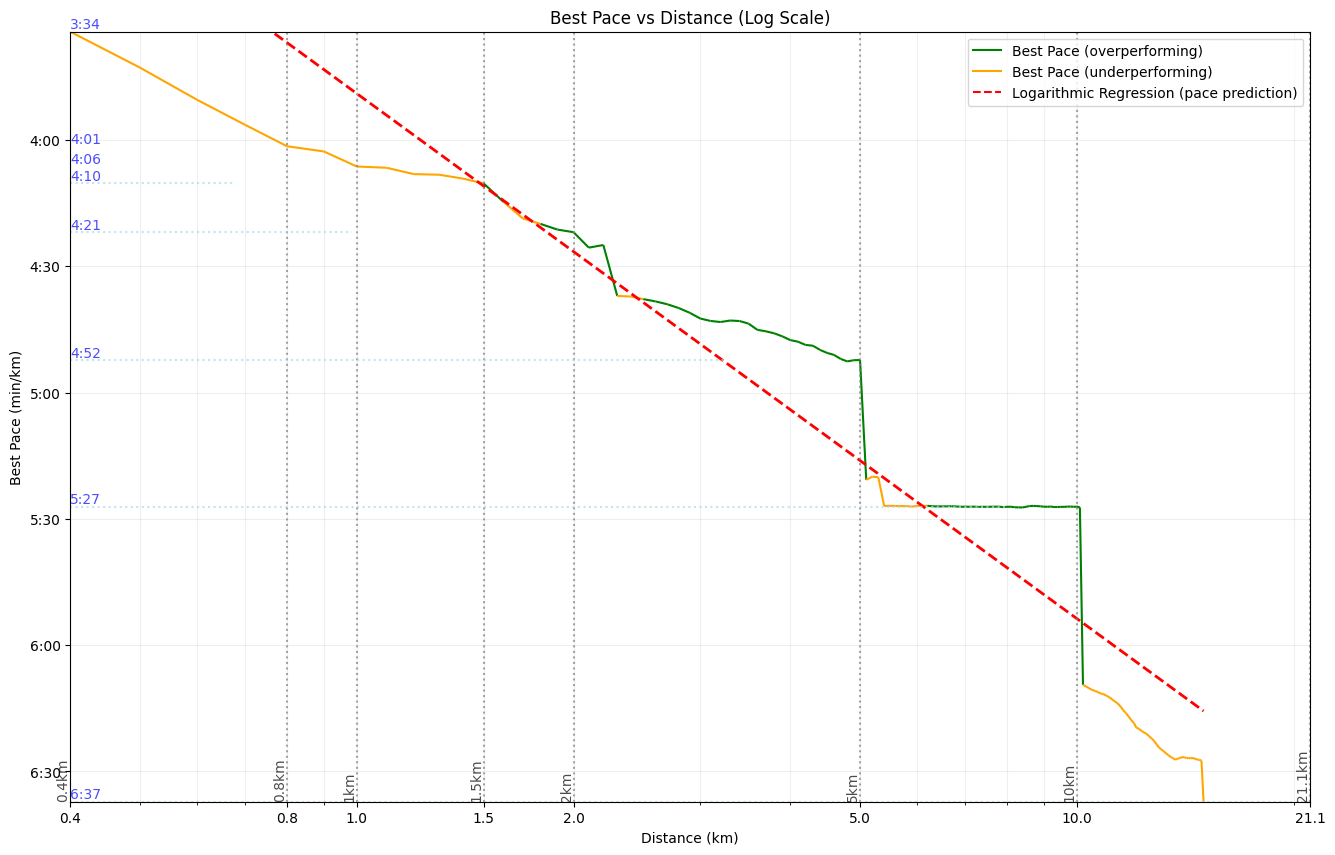

Plot saved as output\best_pace_vs_distance_log_min400_max15000_step100.png


In [50]:
def format_pace_df(pace_seconds_per_km):
    if np.isinf(pace_seconds_per_km) or np.isnan(pace_seconds_per_km):
        return "N/A"
    minutes, seconds = divmod(int(pace_seconds_per_km), 60)
    return f"{minutes}:{seconds:02d}"

# Create DataFrame
df = pd.DataFrame({
    'distance': distances,
    'best_pace': best_paces,
    'regression_curve': regression_curve
})

# Add formatted pace columns
df['best_pace_formatted'] = df['best_pace'].apply(format_pace_df)
df['regression_curve_formatted'] = df['regression_curve'].apply(format_pace_df)

# Ensure output folder exists
output_folder = 'output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save the data to a CSV file with parameters in the filename
csv_filename = os.path.join(output_folder, f'best_pace_data_min{MIN_DISTANCE}_max{MAX_DISTANCE}_step{STEP}.csv')
df.to_csv(csv_filename, index=False)
print(f"Data saved as {csv_filename}")

# Plot and save the graph
plot_best_pace_vs_distance(distances, best_paces, regression_curve, MIN_DISTANCE, MAX_DISTANCE, STEP)

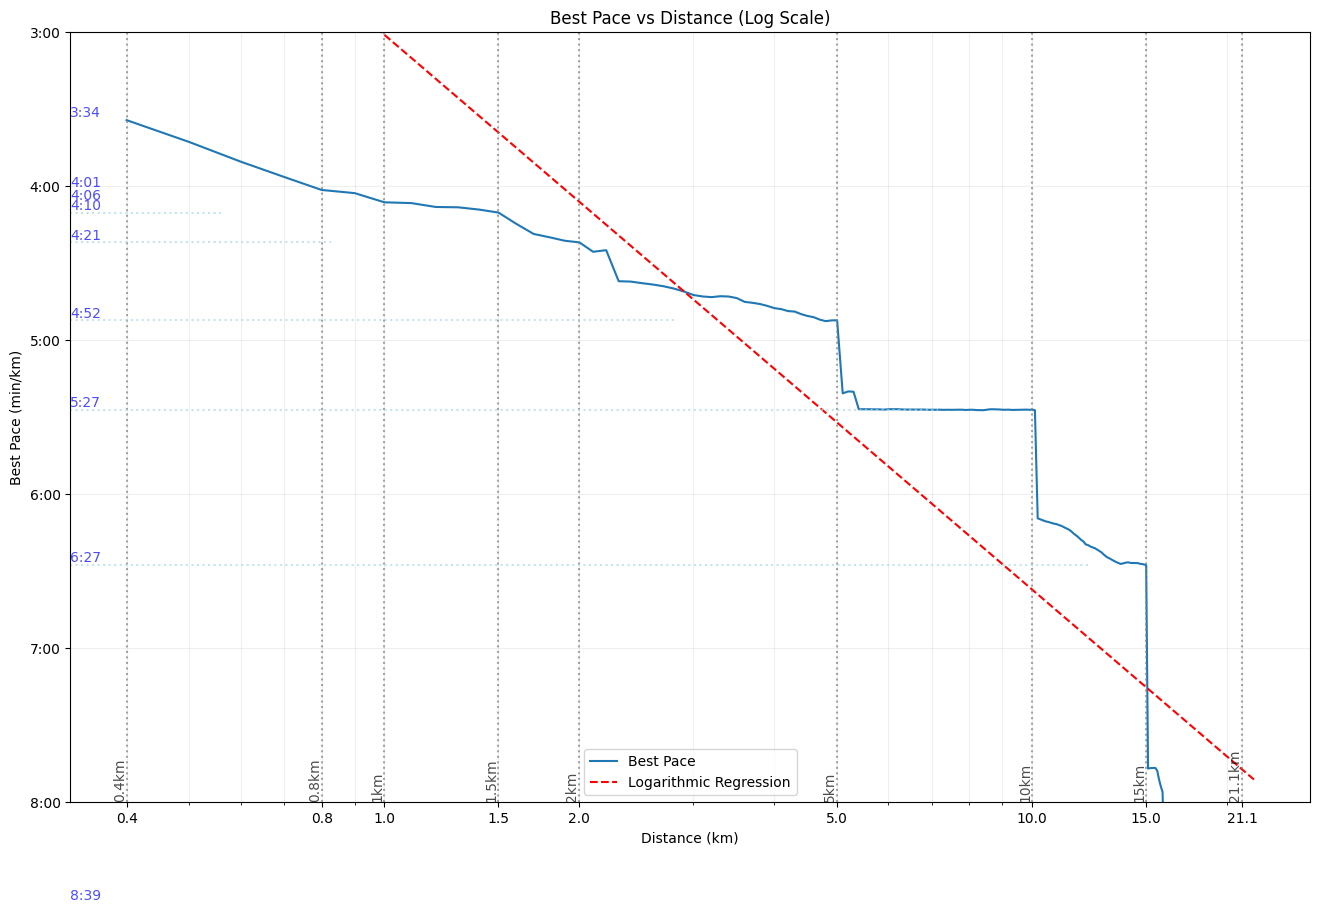

Plot saved as best_pace_vs_distance_log_min400_max22000_step100.png


In [31]:
#To load and use the saved data in future sessions, you can do:
import pandas as pd
import matplotlib.pyplot as plt

# Define the parameters used
MIN_DISTANCE = 400
MAX_DISTANCE = 22000
STEP = 100

# Load the saved data
csv_filename = f'output/best_pace_data_min{MIN_DISTANCE}_max{MAX_DISTANCE}_step{STEP}.csv'
df = pd.read_csv(csv_filename)

# Plot using the loaded data
plot_best_pace_vs_distance(df['distance'], df['best_pace'], df['regression_curve'], MIN_DISTANCE, MAX_DISTANCE, STEP)


## Compare Individual Runs
We can compare a specific run against the all-time PR curve.

In [39]:
# Compute Best Pace for a Specific Run
def compute_run_pace(activity_id, min_distance=100, max_distance=None, step=100):
    time_data, distance_data = process_run(activity_id)
    max_run_distance = distance_data[-1]
    if max_distance is None or max_distance > max_run_distance:
        max_distance = max_run_distance

    distances, best_paces = compute_best_pace(
        time_data,
        distance_data,
        min_distance=min_distance,
        max_distance=max_distance,
        step=step
    )
    return distances, best_paces


In [40]:
# Plot comparison
def plot_run_vs_pr(distances, overall_best_paces, run_paces, run_date):
    import matplotlib.pyplot as plt

    # Convert pace to min/km
    overall_paces_min_per_km = overall_best_paces / 60
    run_paces_min_per_km = run_paces / 60

    plt.figure(figsize=(12, 6))
    plt.plot(distances / 1000, overall_paces_min_per_km, label='All-time PR')
    plt.plot(distances / 1000, run_paces_min_per_km, label=f'Run on {run_date}')
    plt.xlabel('Distance (km)')
    plt.ylabel('Pace (min/km)')
    plt.title('Run vs All-time PR')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend()
    plt.show()



### Execute the Comparison


ValueError: x and y must have same first dimension, but have shapes (72,) and (220,)

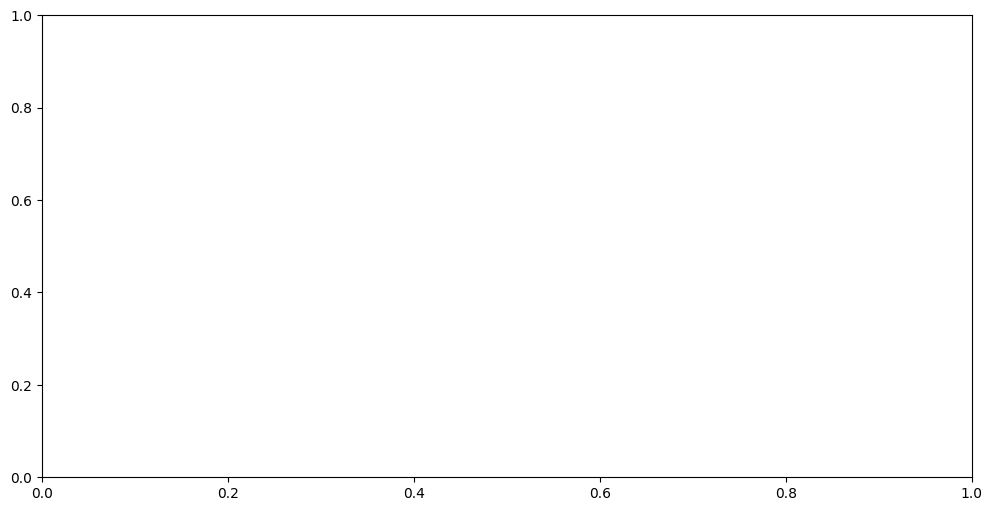

In [41]:
# Choose a run to compare
activity_id = activity_ids[0]  # Replace with desired activity ID

# Compute run pace
run_distances, run_best_paces = compute_run_pace(
    activity_id,
    min_distance=MIN_DISTANCE,
    max_distance=MAX_DISTANCE,
    step=STEP
)

# Get run date
run_date = running_activities[running_activities['id'] == activity_id]['start_date'].values[0]

# Plot comparison
plot_run_vs_pr(run_distances, best_paces, run_best_paces, run_date)
